In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# import all libraries
import numpy as np
import sklearn.model_selection
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
import torchvision.transforms as transforms
from collections import Counter
from pathlib import Path
from io import BytesIO

from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# import games in csv
csv_path = r"drive/MyDrive/deep learning/filtered_games_20_players.csv"

# Data loading
data = pd.read_csv(csv_path) # loading into dataframe


/tmp/ipython-input-836723816.py:32: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(csv_path) # loading into dataframe


In [30]:
# Here we train an RNN (with LSTM) predicting which player from the pool
# has participated in the game based on only the played moves.

NEW_LIST_OF_PLAYERS_MANUAL = [
    'ArasanX',
    'MassterofMayhem',
    'JelenaZ',
    'lestri',
    'doreality',
    'therealYardbird',
    'Chesssknock',
    'No_signs_of_V',
    'Recobachess',
    'drawingchest',
    'kasparik_garik',
    'ChainsOfFantasia',
    'Consent_to_treatment',
    'Alexandr_KhleBovich',
    'unknown-maestro_2450',
    'gefuehlter_FM',
    'gmmitkov',
    'positionaloldman',
    "Carlsen, Magnus",
    "Nakamura, Hikaru"]

# Initialize batch size, needs to be big here for faster
# simulations on the laptop, and smaller when using LUMI
BATCH_SIZE = 32

# Define the lngth of the games (small for laptop and
# big when using LUMI)
GAME_LENGTH = 100

# Step size / Learning rate for the Adam optimizer
LEARNING_RATE = 2e-3

# Iterations / Epochs
EPOCHS = 50

# LSTM hidden dimension
HIDDEN_LAYER_DIM = 128

# Embedding dimension
EMBEDDED_LAYER_DIM = 128

# we set names (coloumns) as strings
data["white_name"] = data["white_name"].astype(str)
data["black_name"] = data["black_name"].astype(str)

def player_match(name : str):
    # Return player name if in sub-string
    lowered = name.lower()
    for player in NEW_LIST_OF_PLAYERS_MANUAL:
        if player.lower() == lowered:
            return player
    return None

# Now determining player of each game
w = data["white_name"].apply(player_match)
b = data["black_name"].apply(player_match)
data["PlayerLabel"] = w.fillna(b) # if not white go back to black

# Remove all other games
data = data.dropna(subset=["PlayerLabel"]).reset_index(drop=True)

# now we map locally
encodep = dict(zip(NEW_LIST_OF_PLAYERS_MANUAL, range(len(NEW_LIST_OF_PLAYERS_MANUAL))))
decodep = {m: l for l, m in encodep.items()}

# we make a temperory split for training tokenization
dat_temp = data
l = len(dat_temp)

traindata, _, _ = random_split(
    range(l),
    [int(l*0.8), int(l*0.1), l - int(l*0.8) - int(l*0.1)], # test data
    generator=torch.Generator().manual_seed(123) # seed
)


In [31]:
# --- TOKENIZATION --- (from used steps/moves)

# Using cleaner to take unwanted things out
cleaner = str.maketrans({"[": "", "]": "", "'": "", ",": ""})
all_step = [ # flatten moves from games
    k
    for s in data.loc[traindata.indices, "list_of_moves"]
    for k in s.translate(cleaner).split()
]
# count frequency of moves
frequency = Counter(all_step)

# keeping it simple (just anything we dont know)
dir = {"<PAD>": 0, "<UNK>": 1}
# Assign id
dir.update({n: len(dir) + i for i, n in enumerate(frequency)})


def step_encode(step): # convert raw mos into tokens
    # This pads using zeroes and trunctaes with game-lenth
    cleaned = step.translate(str.maketrans({"[": "", "]": "", "'": "", ",": ""}))
    tokening = cleaned.split()
    # use ids
    # use UNK(1) when it is unknown
    vector = list(map(lambda i_token: dir.get(i_token, 1), tokening[: GAME_LENGTH]))
    pad = np.zeros(GAME_LENGTH - len(vector), dtype=int).tolist()
    vector = vector + pad
    return vector


In [32]:
# --- DATA PREPARATION ---
TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
MANUAL_SEED = 123

class GameSequence(Dataset): # wrapping dataset
    def __init__(object, wind): # store frame
        object.win = wind
        # convert names inot int labeling for class
        object.labels = wind["PlayerLabel"].map(encodep).to_list()
        object.moves  = wind["list_of_moves"].to_list() # save for encoding

    def __len__(object): # pytorch standard
        length = object.win.__len__() # nr of samples
        return length

    def __getitem__(object, m): # get training from index
        # id's of tokens
        x = torch.tensor(step_encode(object.moves[m]), dtype=torch.long)
        # player
        y = torch.tensor(object.labels[m], dtype=torch.long)
        return x, y

# Now we spilt the data into train, validation and
# test data as learnt in the lectures

prepared_game_sequence_data = GameSequence(data)
train_data, validation_data, test_data = random_split(
    prepared_game_sequence_data,
    [int(len(prepared_game_sequence_data) * TRAIN_SPLIT),       # train data
     int(len(prepared_game_sequence_data) * VALIDATION_SPLIT),  # validation data
     len(prepared_game_sequence_data) - int(len(prepared_game_sequence_data) * TRAIN_SPLIT) - int(len(prepared_game_sequence_data) * VALIDATION_SPLIT)], # test data
    generator=torch.Generator().manual_seed(MANUAL_SEED)
)

# Suffle only train, not the others
TRAIN_DATALOADER = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
VALIDATION_DATALOADER = DataLoader(validation_data, batch_size = BATCH_SIZE)
TEST_DATALOADER = DataLoader(test_data, batch_size = BATCH_SIZE)

# Cross Entropy loss (ideal and simple for classification tasks)
loss_fn = nn.CrossEntropyLoss()

In [33]:
# --- THE RNN MODEL ---

class RecurrentNN(nn.Module):
    def __init__(self, dir, dim_embedded, dim_hidden_layer, dim_out):
        super(RecurrentNN, self).__init__() # initilaze pytorch nn.module

        # lookup table for the tokens
        self.table = nn.Embedding( # embedding for tokens
            num_embeddings=dir,
            embedding_dim=dim_embedded,  # size of embeddings
            padding_idx=0  # telling torch 0's are padding, not actual moves
        )

        # Core
        self.core = nn.LSTM( # lstm core
            input_size=dim_embedded, # use embedding vector
            # hidden dimension
            hidden_size=dim_hidden_layer,
            # 2 layers for a bit better results
            num_layers=2,
            batch_first=True,
            bidirectional=True, # backward and forward
            dropout=0.25 # minimizing overfitting (drop 25% units randomly)
            # For 2 layers it is ignored but for layers >= 3 (for later) it is good to have
        )

        # projection block outputting
        self.proj = nn.Sequential( # classifier part
            nn.Dropout(0.35), # same like before (being less dependent on single neurons)
            nn.Linear(2 * dim_hidden_layer, dim_out) # since bidirectional
        )

    def forward(self, x): # input flow
        x = self.table(x) # embedding tokens
        _,(state,_) = self.core(x) # running sequence

        # now we have the Last backward and forward states (hidden)
        fowardstate  = state[-2] # for 2 layers
        backwardstate = state[-1]

        # here we have a single vector concatenation
        vector = torch.cat([fowardstate, backwardstate], dim=1)

        return self.proj(vector)

model = RecurrentNN( # Building model
    dir=len(dir),
    dim_embedded=EMBEDDED_LAYER_DIM,
    dim_hidden_layer=HIDDEN_LAYER_DIM,
    dim_out=len(encodep)
).to(device)

# For RNN's, ADAM is the way to go.
optimizer = torch.optim.Adam(params=list(model.parameters()), lr=LEARNING_RATE)


In [34]:
def train_validate(train_loader: DataLoader,
                   validation_loader: DataLoader,
                   model: nn.Module,
                   optimizer,
                   scheduler,
                   device: torch.device,
                   alpha=0.2):
    model.train() # training mode activation before updating gradients

    # Initialize variables
    batch_losses_train = []  # each batch, the loss is stored and later averaged to get an average train loss per epoch

    # used for f1 score and accuracy metrics
    pred_labels_train = []
    true_labels_train = []

    for xbatch, ybatch in tqdm(train_loader, colour='green'): # iterating batches
        xbatch = xbatch.to(device)
        ybatch = ybatch.to(device)

        # reset from last batch
        optimizer.zero_grad()
        output = model(xbatch)
        loss = loss_fn(output, ybatch)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(output, dim=1)

        batch_losses_train.append(loss.item())
        pred_labels_train.append(preds)
        true_labels_train.append(ybatch)

    # Format useful lists for calculation of metrics
    pred_labels_train = torch.cat(pred_labels_train, dim=0).detach().cpu().numpy().flatten()
    true_labels_train = torch.cat(true_labels_train, dim=0).detach().cpu().numpy().flatten()

    avg_train_loss = np.mean(batch_losses_train)

    # VALIDATE
    model.eval()

    # Initialize variables
    batch_losses_val = []  # each batch, the loss is stored and later averaged to get an average train loss per epoch

    # used for f1 score and accuracy metrics
    pred_labels_val = []
    true_labels_val = []

    with torch.no_grad(): # without gradient update for evaluation
        for xbatch, ybatch in validation_loader:
            xbatch = xbatch.to(device)
            ybatch = ybatch.to(device)

            output = model(xbatch)
            loss = loss_fn(output, ybatch)

            batch_losses_val.append(loss.item())

            preds = torch.argmax(output, dim=1)

            pred_labels_val.append(preds)
            true_labels_val.append(ybatch)

    avg_val_loss = np.mean(batch_losses_val)

    # Format useful lists for calculation of metrics
    pred_labels_val = torch.cat(pred_labels_val, dim=0).cpu().detach().numpy().flatten()
    true_labels_val = torch.cat(true_labels_val, dim=0).cpu().detach().numpy().flatten()

    return avg_train_loss, avg_val_loss, \
        (pred_labels_train, true_labels_train), \
        (pred_labels_val, true_labels_val)

def test(test_loader: DataLoader,
         model: nn.Module,
         device: torch.device,
         alpha=0.2):
    # Now we test on the test data at the end

    model.eval()

    # Initialize variables
    batch_losses_test = []  # each batch, the loss is stored and later averaged to get an average train loss per epoch

    # used for f1 score and accuracy metrics
    pred_labels_test = []
    true_labels_test = []

    with torch.no_grad(): # without gradient update for evaluation
        for xbatch, ybatch in test_loader:
            xbatch = xbatch.to(device)
            ybatch = ybatch.to(device)

            output = model(xbatch)
            loss = loss_fn(output, ybatch)

            batch_losses_test.append(loss.item())

            preds = torch.argmax(output, dim=1)

            pred_labels_test.append(preds)
            true_labels_test.append(ybatch)

    avg_test_loss = np.mean(batch_losses_test)

    # Format useful lists for calculation of metrics
    pred_labels_test = torch.cat(pred_labels_test, dim=0).cpu().detach().numpy().flatten()
    true_labels_test = torch.cat(true_labels_test, dim=0).cpu().detach().numpy().flatten()

    return avg_test_loss, (pred_labels_test, true_labels_test)


In [35]:

'''
To calculate different kind of metrics based on:
- Average (train/validation/test) loss
- Predicted labels for training/validation/test
- True labels for training/validation/test

Calculates:
- Classification metrics
    - F1 scores (macro, weighted, per-class)
    - Confusion matrix (and prints)
    - Classification report
    - Balanced accuracy score
- Regression metrics
    - Mean absolute error
    - (root) mean squared error
    - R2 score

Shows:
    - Confusion matrix
    - Predicted vs True regression plot
'''
def calculateMetrics(avg_loss : np.ndarray, predicted_labels : np.ndarray, true_labels : np.ndarray):
    # --- CLASSIFICATION ---
    '''
    Macro F1 = The average f1 score over all classes, treating each class equally.
    This score becomes more relevant when some players have very few games.
    '''
    macro_f1 = f1_score(true_labels, predicted_labels, average="macro")

    '''
    Weighted F1 = Same as Macro F1, but is weighted by class frequency. It doesn't punish too hard for players with few games.
    '''
    weighted_f1 = f1_score(true_labels, predicted_labels, average="weighted")

    '''
    Per-class F1 scores, this doesn't average over all classes and shows how different players compare
    Is not printed, because classification_report already does it in a nice way, but wanted to include here
    Because it shows the relevance.
    '''
    per_class_f1 = f1_score(true_labels, predicted_labels, average=None)

    '''
    A full on confusion matrix of shape NxN.
    '''
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    '''
    Balanced accuracy = Each class contributes equally to the accuracy, better than the usual way of calculating accuracy: correct / total
    '''
    bal_accuracy = balanced_accuracy_score(true_labels, predicted_labels)

    print(
        f"--- CLASSIFICATION METRICS --- \n"
        f"F1 scores: [Macro={macro_f1:.3f}, Weighted={weighted_f1:.3f}] \n"
        f"Balanced Accuracy = {bal_accuracy:.3f}"
        f"Average loss = {avg_loss:.5f}")

    report = classification_report(true_labels, predicted_labels, output_dict=True)
    df = pd.DataFrame(report).transpose()
    print(tabulate(df.round(3), headers='keys', tablefmt="pretty"))

    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=False, cmap="Blues")
    plt.title("Confusion matrix")
    plt.show()


Beginning training... using cuda device


100%|██████████| 9305/9305 [01:42<00:00, 90.77it/s]


Epoch 0, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.505, Weighted=0.538] 
Balanced Accuracy = 0.517Average loss = 1.53484
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.603   | 0.672  |  0.635   | 21749.0  |
|      1       |   0.587   | 0.696  |  0.637   | 20509.0  |
|      2       |   0.556   | 0.597  |  0.576   | 19253.0  |
|      3       |   0.721   | 0.852  |  0.781   | 18405.0  |
|      4       |   0.336   | 0.285  |  0.308   | 17408.0  |
|      5       |   0.618   | 0.669  |  0.642   | 17137.0  |
|      6       |   0.579   | 0.666  |   0.62   | 16856.0  |
|      7       |   0.684   | 0.791  |  0.734   | 16452.0  |
|      8       |   0.647   | 0.726  |  0.685   | 15891.0  |
|      9       |   0.28    | 0.173  |  0.214   | 14502.0  |
|      10      |   0.49    | 0.455  |  0.472   | 14497.0  |
|      11  

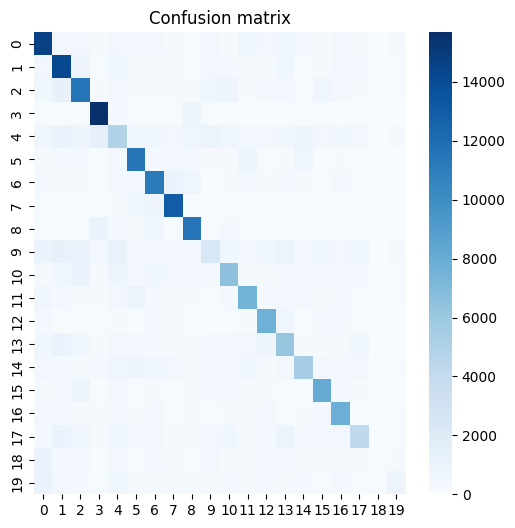

Epoch 0, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.538, Weighted=0.572] 
Balanced Accuracy = 0.552Average loss = 1.40210
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.574   | 0.755  |  0.652   | 2665.0  |
|      1       |   0.675   | 0.703  |  0.689   | 2654.0  |
|      2       |   0.565   | 0.638  |  0.599   | 2384.0  |
|      3       |   0.773   | 0.847  |  0.808   | 2269.0  |
|      4       |   0.405   | 0.307  |  0.349   | 2147.0  |
|      5       |   0.657   | 0.733  |  0.693   | 2179.0  |
|      6       |   0.653   | 0.632  |  0.643   | 2059.0  |
|      7       |   0.683   | 0.865  |  0.763   | 2106.0  |
|      8       |   0.642   | 0.785  |  0.707   | 2016.0  |
|      9       |   0.336   | 0.205  |  0.255   | 1860.0  |
|      10      |   0.525   | 0.464  |  0.493   | 1690.0  |
|      11      |   0.61

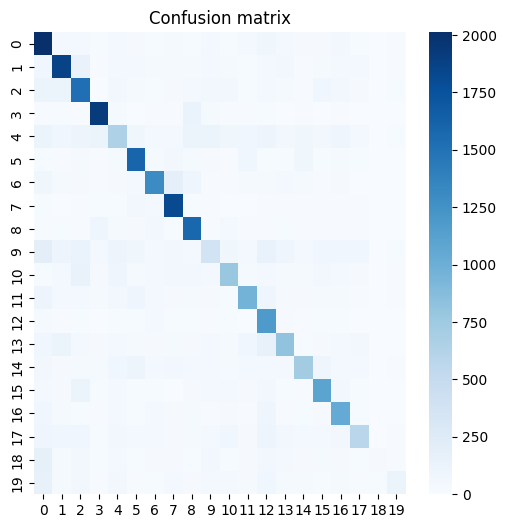

100%|██████████| 9305/9305 [01:41<00:00, 91.49it/s]


Epoch 1, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.528, Weighted=0.561] 
Balanced Accuracy = 0.538Average loss = 1.46266
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.625   | 0.701  |  0.661   | 21749.0  |
|      1       |   0.618   | 0.717  |  0.664   | 20509.0  |
|      2       |   0.582   | 0.614  |  0.598   | 19253.0  |
|      3       |   0.736   | 0.857  |  0.792   | 18405.0  |
|      4       |   0.36    | 0.309  |  0.332   | 17408.0  |
|      5       |   0.64    | 0.691  |  0.665   | 17137.0  |
|      6       |   0.599   | 0.678  |  0.636   | 16856.0  |
|      7       |   0.705   | 0.801  |   0.75   | 16452.0  |
|      8       |   0.666   |  0.74  |  0.701   | 15891.0  |
|      9       |   0.293   | 0.199  |  0.237   | 14502.0  |
|      10      |   0.509   |  0.48  |  0.494   | 14497.0  |
|      11  

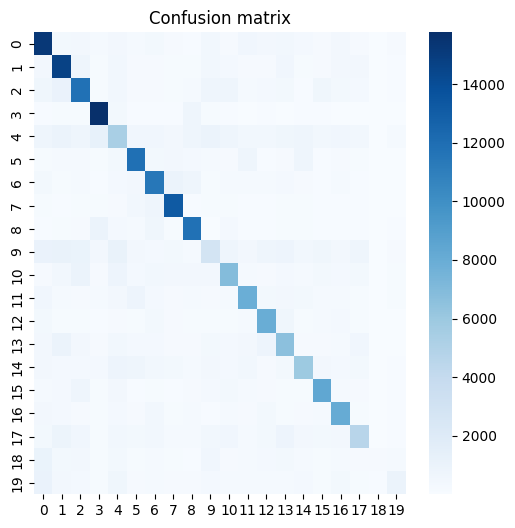

Epoch 1, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.549, Weighted=0.583] 
Balanced Accuracy = 0.561Average loss = 1.37669
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.653   | 0.727  |  0.688   | 2665.0  |
|      1       |   0.669   | 0.725  |  0.696   | 2654.0  |
|      2       |   0.578   | 0.634  |  0.605   | 2384.0  |
|      3       |   0.741   | 0.893  |   0.81   | 2269.0  |
|      4       |   0.382   | 0.308  |  0.341   | 2147.0  |
|      5       |   0.651   | 0.738  |  0.692   | 2179.0  |
|      6       |   0.573   | 0.723  |  0.639   | 2059.0  |
|      7       |    0.7    | 0.839  |  0.763   | 2106.0  |
|      8       |   0.666   | 0.775  |  0.717   | 2016.0  |
|      9       |   0.362   | 0.202  |  0.259   | 1860.0  |
|      10      |   0.558   | 0.477  |  0.514   | 1690.0  |
|      11      |   0.59

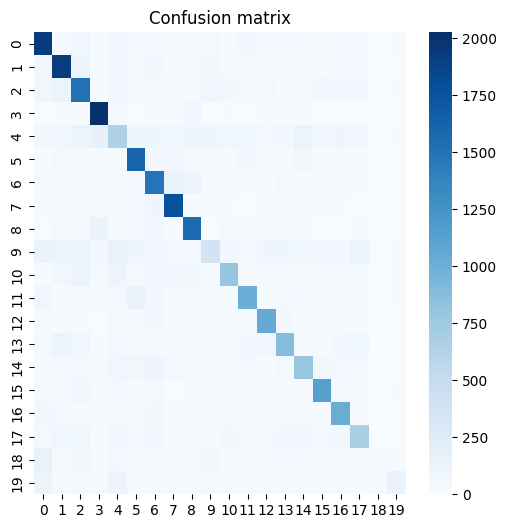

100%|██████████| 9305/9305 [01:42<00:00, 90.71it/s]


Epoch 2, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.534, Weighted=0.567] 
Balanced Accuracy = 0.544Average loss = 1.44158
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.633   |  0.71  |   0.67   | 21749.0  |
|      1       |   0.624   | 0.719  |  0.668   | 20509.0  |
|      2       |   0.585   | 0.618  |  0.601   | 19253.0  |
|      3       |   0.744   | 0.861  |  0.798   | 18405.0  |
|      4       |   0.361   | 0.314  |  0.336   | 17408.0  |
|      5       |   0.65    | 0.697  |  0.672   | 17137.0  |
|      6       |   0.601   | 0.685  |   0.64   | 16856.0  |
|      7       |   0.711   | 0.811  |  0.758   | 16452.0  |
|      8       |   0.672   | 0.743  |  0.706   | 15891.0  |
|      9       |   0.304   | 0.206  |  0.245   | 14502.0  |
|      10      |   0.522   | 0.491  |  0.506   | 14497.0  |
|      11  

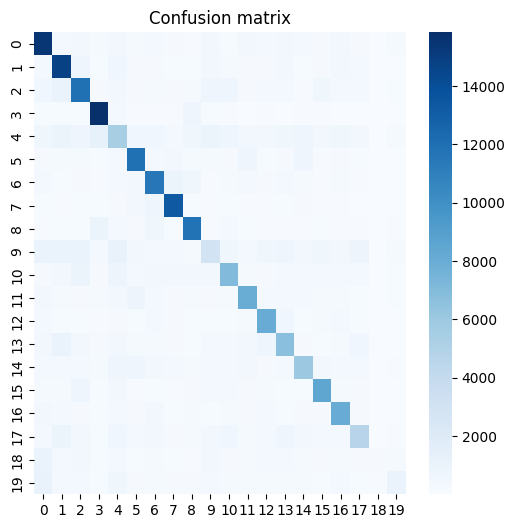

Epoch 2, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.557, Weighted=0.590] 
Balanced Accuracy = 0.569Average loss = 1.35765
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.633   | 0.749  |  0.686   | 2665.0  |
|      1       |   0.672   | 0.722  |  0.696   | 2654.0  |
|      2       |   0.681   | 0.561  |  0.615   | 2384.0  |
|      3       |   0.757   | 0.863  |  0.806   | 2269.0  |
|      4       |   0.416   | 0.337  |  0.373   | 2147.0  |
|      5       |   0.697   | 0.704  |   0.7    | 2179.0  |
|      6       |   0.638   |  0.66  |  0.649   | 2059.0  |
|      7       |   0.709   | 0.853  |  0.774   | 2106.0  |
|      8       |   0.66    | 0.786  |  0.718   | 2016.0  |
|      9       |   0.341   | 0.234  |  0.278   | 1860.0  |
|      10      |   0.508   | 0.529  |  0.518   | 1690.0  |
|      11      |   0.58

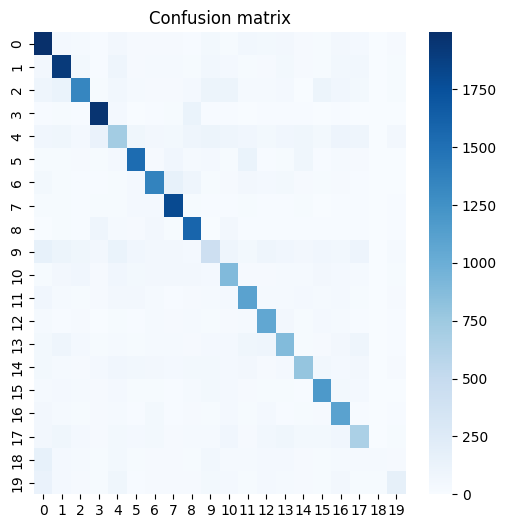

100%|██████████| 9305/9305 [01:42<00:00, 91.06it/s]


Epoch 3, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.537, Weighted=0.571] 
Balanced Accuracy = 0.547Average loss = 1.43135
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.632   | 0.715  |  0.671   | 21749.0  |
|      1       |   0.629   |  0.72  |  0.672   | 20509.0  |
|      2       |   0.589   |  0.62  |  0.604   | 19253.0  |
|      3       |   0.744   | 0.863  |  0.799   | 18405.0  |
|      4       |   0.372   | 0.329  |  0.349   | 17408.0  |
|      5       |   0.655   |  0.7   |  0.677   | 17137.0  |
|      6       |   0.604   |  0.69  |  0.645   | 16856.0  |
|      7       |   0.711   | 0.809  |  0.757   | 16452.0  |
|      8       |   0.677   | 0.746  |   0.71   | 15891.0  |
|      9       |   0.307   | 0.212  |  0.251   | 14502.0  |
|      10      |   0.529   | 0.488  |  0.508   | 14497.0  |
|      11  

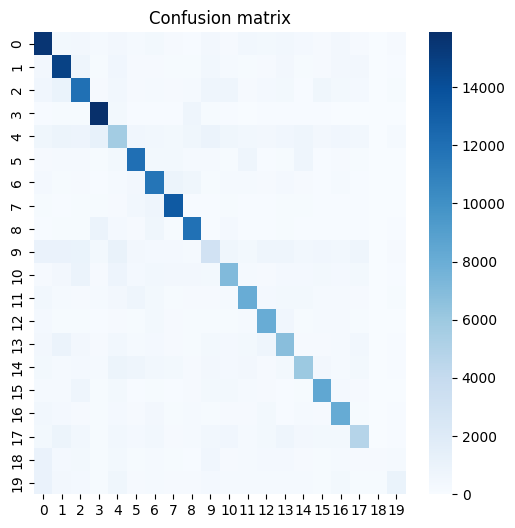

Epoch 3, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.556, Weighted=0.590] 
Balanced Accuracy = 0.567Average loss = 1.35437
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.653   | 0.731  |  0.689   | 2665.0  |
|      1       |   0.659   | 0.742  |  0.698   | 2654.0  |
|      2       |   0.597   |  0.63  |  0.613   | 2384.0  |
|      3       |   0.744   | 0.882  |  0.807   | 2269.0  |
|      4       |   0.415   |  0.34  |  0.374   | 2147.0  |
|      5       |   0.691   | 0.722  |  0.706   | 2179.0  |
|      6       |   0.622   | 0.677  |  0.648   | 2059.0  |
|      7       |   0.703   | 0.859  |  0.774   | 2106.0  |
|      8       |   0.667   | 0.789  |  0.723   | 2016.0  |
|      9       |   0.363   | 0.227  |  0.279   | 1860.0  |
|      10      |   0.464   | 0.561  |  0.508   | 1690.0  |
|      11      |   0.64

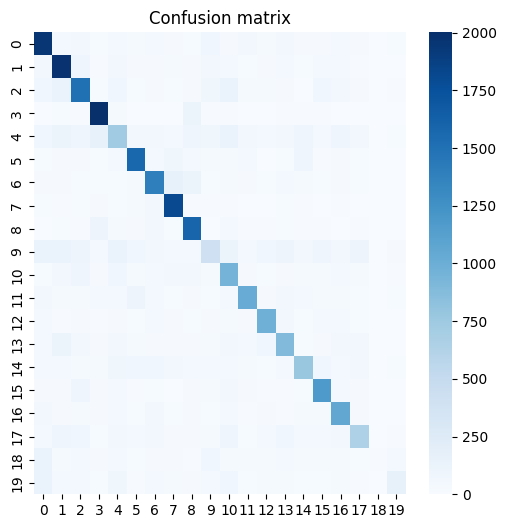

100%|██████████| 9305/9305 [01:55<00:00, 80.50it/s]


Epoch 4, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.536, Weighted=0.570] 
Balanced Accuracy = 0.546Average loss = 1.43360
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.634   | 0.721  |  0.675   | 21749.0  |
|      1       |   0.627   | 0.723  |  0.671   | 20509.0  |
|      2       |   0.589   | 0.618  |  0.604   | 19253.0  |
|      3       |   0.743   | 0.859  |  0.797   | 18405.0  |
|      4       |   0.37    | 0.323  |  0.345   | 17408.0  |
|      5       |   0.654   | 0.696  |  0.674   | 17137.0  |
|      6       |   0.604   |  0.68  |   0.64   | 16856.0  |
|      7       |   0.713   | 0.812  |  0.759   | 16452.0  |
|      8       |   0.674   | 0.745  |  0.708   | 15891.0  |
|      9       |    0.3    | 0.207  |  0.245   | 14502.0  |
|      10      |   0.521   | 0.489  |  0.504   | 14497.0  |
|      11  

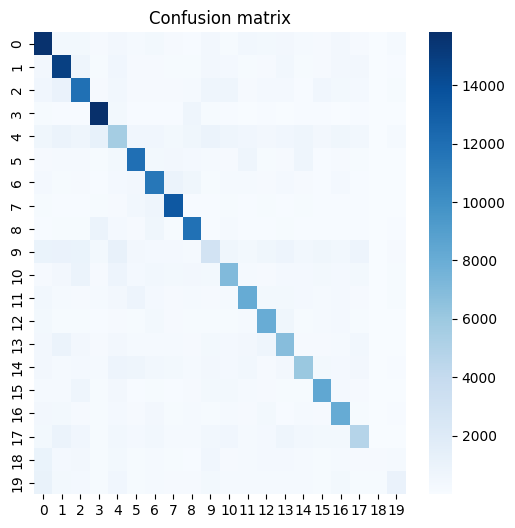

Epoch 4, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.558, Weighted=0.591] 
Balanced Accuracy = 0.568Average loss = 1.35030
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.662   | 0.721  |   0.69   | 2665.0  |
|      1       |   0.645   | 0.756  |  0.696   | 2654.0  |
|      2       |   0.624   | 0.608  |  0.616   | 2384.0  |
|      3       |   0.735   |  0.9   |  0.809   | 2269.0  |
|      4       |   0.409   | 0.315  |  0.356   | 2147.0  |
|      5       |   0.655   | 0.747  |  0.698   | 2179.0  |
|      6       |   0.616   | 0.711  |   0.66   | 2059.0  |
|      7       |   0.749   | 0.826  |  0.785   | 2106.0  |
|      8       |   0.691   | 0.759  |  0.723   | 2016.0  |
|      9       |   0.332   | 0.258  |   0.29   | 1860.0  |
|      10      |   0.528   |  0.51  |  0.519   | 1690.0  |
|      11      |   0.60

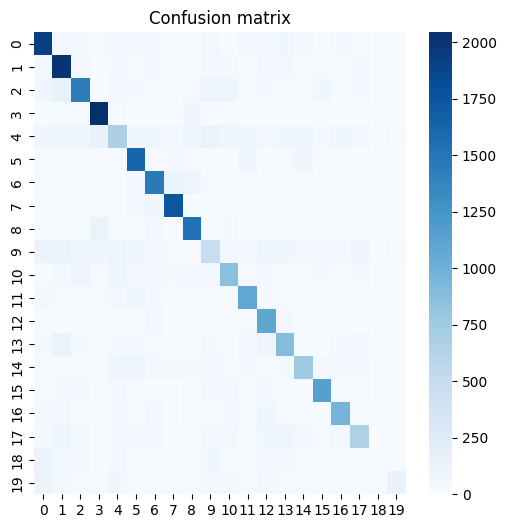

100%|██████████| 9305/9305 [01:43<00:00, 89.78it/s]


Epoch 5, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.535, Weighted=0.568] 
Balanced Accuracy = 0.545Average loss = 1.43677
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.639   |  0.72  |  0.677   | 21749.0  |
|      1       |   0.621   | 0.721  |  0.667   | 20509.0  |
|      2       |   0.587   | 0.617  |  0.601   | 19253.0  |
|      3       |   0.74    | 0.858  |  0.795   | 18405.0  |
|      4       |   0.371   |  0.32  |  0.344   | 17408.0  |
|      5       |   0.652   | 0.689  |   0.67   | 17137.0  |
|      6       |   0.603   | 0.682  |   0.64   | 16856.0  |
|      7       |   0.711   | 0.806  |  0.755   | 16452.0  |
|      8       |   0.669   | 0.745  |  0.705   | 15891.0  |
|      9       |   0.303   | 0.213  |   0.25   | 14502.0  |
|      10      |   0.522   | 0.487  |  0.504   | 14497.0  |
|      11  

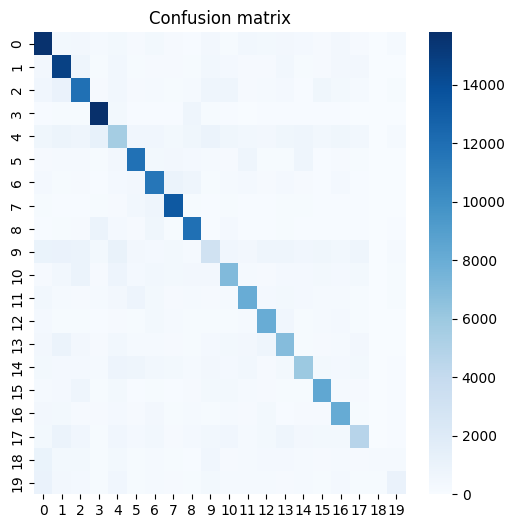

Epoch 5, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.552, Weighted=0.586] 
Balanced Accuracy = 0.563Average loss = 1.36592
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.678   |  0.71  |  0.694   | 2665.0  |
|      1       |   0.636   | 0.765  |  0.694   | 2654.0  |
|      2       |   0.589   | 0.624  |  0.606   | 2384.0  |
|      3       |   0.743   | 0.881  |  0.806   | 2269.0  |
|      4       |   0.39    | 0.343  |  0.365   | 2147.0  |
|      5       |   0.669   | 0.742  |  0.704   | 2179.0  |
|      6       |   0.595   | 0.724  |  0.653   | 2059.0  |
|      7       |   0.737   | 0.828  |   0.78   | 2106.0  |
|      8       |   0.694   | 0.746  |  0.719   | 2016.0  |
|      9       |   0.32    | 0.208  |  0.252   | 1860.0  |
|      10      |   0.524   | 0.499  |  0.512   | 1690.0  |
|      11      |   0.58

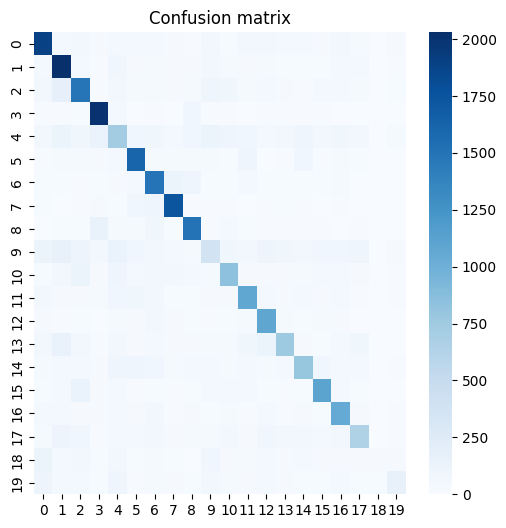

100%|██████████| 9305/9305 [01:43<00:00, 89.76it/s]


Epoch 6, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.533, Weighted=0.566] 
Balanced Accuracy = 0.543Average loss = 1.44551
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.633   | 0.721  |  0.674   | 21749.0  |
|      1       |   0.62    | 0.714  |  0.663   | 20509.0  |
|      2       |   0.585   | 0.615  |  0.599   | 19253.0  |
|      3       |   0.742   | 0.861  |  0.797   | 18405.0  |
|      4       |   0.367   | 0.314  |  0.338   | 17408.0  |
|      5       |   0.653   | 0.685  |  0.669   | 17137.0  |
|      6       |   0.606   | 0.679  |   0.64   | 16856.0  |
|      7       |   0.705   | 0.805  |  0.752   | 16452.0  |
|      8       |   0.667   | 0.746  |  0.704   | 15891.0  |
|      9       |   0.299   | 0.212  |  0.248   | 14502.0  |
|      10      |   0.518   |  0.48  |  0.499   | 14497.0  |
|      11  

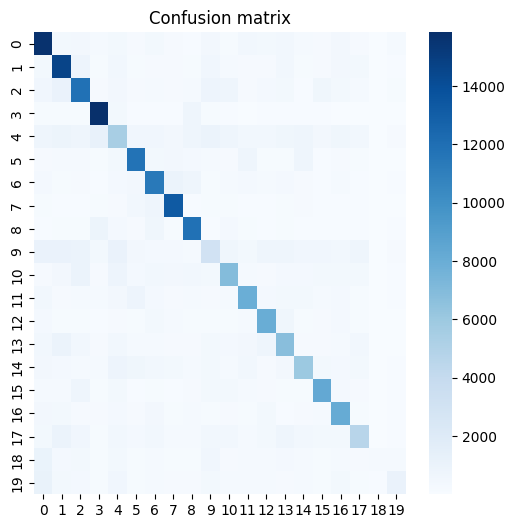

Epoch 6, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.555, Weighted=0.588] 
Balanced Accuracy = 0.565Average loss = 1.36771
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.627   | 0.752  |  0.684   | 2665.0  |
|      1       |   0.636   | 0.739  |  0.684   | 2654.0  |
|      2       |   0.67    |  0.57  |  0.616   | 2384.0  |
|      3       |   0.766   | 0.856  |  0.809   | 2269.0  |
|      4       |   0.378   | 0.359  |  0.368   | 2147.0  |
|      5       |   0.674   | 0.739  |  0.705   | 2179.0  |
|      6       |   0.615   | 0.678  |  0.645   | 2059.0  |
|      7       |   0.729   | 0.831  |  0.777   | 2106.0  |
|      8       |   0.647   | 0.804  |  0.717   | 2016.0  |
|      9       |   0.341   | 0.217  |  0.265   | 1860.0  |
|      10      |   0.515   | 0.512  |  0.513   | 1690.0  |
|      11      |   0.59

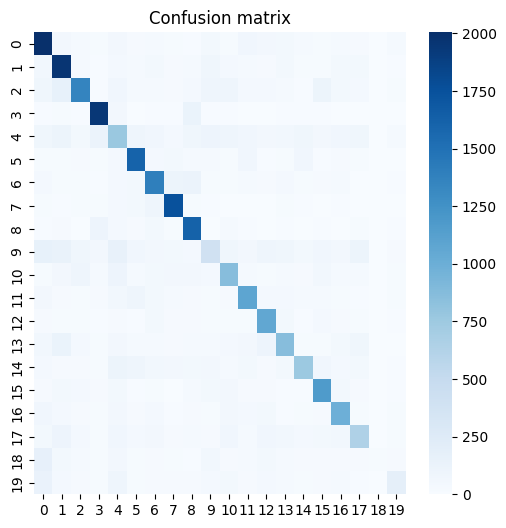

100%|██████████| 9305/9305 [01:44<00:00, 89.08it/s]


Epoch 7, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.530, Weighted=0.563] 
Balanced Accuracy = 0.540Average loss = 1.45598
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.628   | 0.715  |  0.669   | 21749.0  |
|      1       |   0.614   | 0.714  |   0.66   | 20509.0  |
|      2       |   0.579   |  0.61  |  0.594   | 19253.0  |
|      3       |   0.738   | 0.858  |  0.793   | 18405.0  |
|      4       |   0.359   | 0.313  |  0.335   | 17408.0  |
|      5       |   0.643   | 0.685  |  0.663   | 17137.0  |
|      6       |    0.6    |  0.68  |  0.638   | 16856.0  |
|      7       |   0.705   | 0.801  |   0.75   | 16452.0  |
|      8       |   0.664   | 0.746  |  0.703   | 15891.0  |
|      9       |   0.299   | 0.203  |  0.242   | 14502.0  |
|      10      |   0.517   | 0.477  |  0.496   | 14497.0  |
|      11  

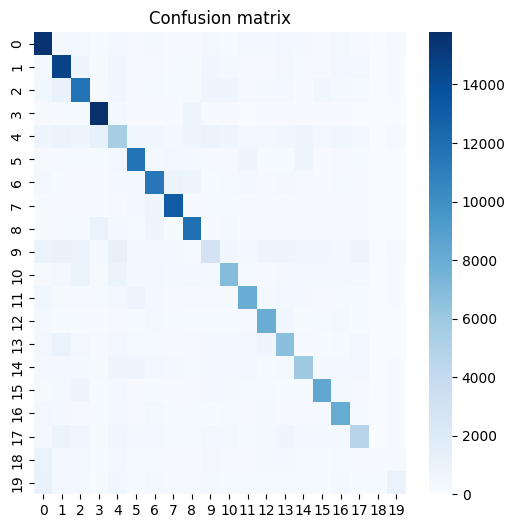

Epoch 7, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.546, Weighted=0.579] 
Balanced Accuracy = 0.559Average loss = 1.38402
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.615   | 0.743  |  0.673   | 2665.0  |
|      1       |   0.616   | 0.749  |  0.676   | 2654.0  |
|      2       |   0.62    | 0.594  |  0.607   | 2384.0  |
|      3       |   0.743   | 0.882  |  0.807   | 2269.0  |
|      4       |   0.413   | 0.291  |  0.342   | 2147.0  |
|      5       |   0.64    | 0.763  |  0.696   | 2179.0  |
|      6       |   0.631   | 0.662  |  0.646   | 2059.0  |
|      7       |   0.721   | 0.824  |  0.769   | 2106.0  |
|      8       |   0.638   | 0.806  |  0.712   | 2016.0  |
|      9       |   0.33    | 0.197  |  0.246   | 1860.0  |
|      10      |   0.505   | 0.499  |  0.502   | 1690.0  |
|      11      |   0.62

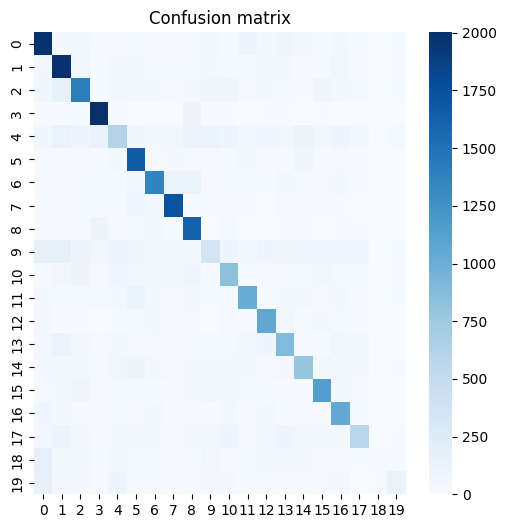

 65%|██████▍   | 6010/9305 [01:06<00:36, 89.78it/s]


KeyboardInterrupt: 

In [38]:
# --- TRAINING, VALIDATION ---
train_losses, val_losses = [], []

# EARLY STOPPING
early_stop_counter = 0  # do not change
early_stop_best_loss = torch.inf
early_stop_best_model_state = None
PATIENCE = 5  # after how many epochs of no decrease in loss should we stop
DELTA = 1e-3  # if the loss decreases with maximum this delta, do not reset the counter

print(f"Beginning training... using {device} device")

for iEpoch in range(EPOCHS):
    t_loss, v_loss, (pltrain, tltrain), (plval, tlval)\
      = train_validate(train_loader=TRAIN_DATALOADER,
                       validation_loader=VALIDATION_DATALOADER,
                       model=model,
                       optimizer=optimizer,
                       scheduler=None,
                       device=device)

    print(f"Epoch {iEpoch}, training metrics:")
    calculateMetrics(t_loss, pltrain, tltrain)

    print(f"Epoch {iEpoch}, validation metrics:")
    calculateMetrics(v_loss, plval, tlval)

    # -- EARLY STOPPING CHECK --
    if v_loss < early_stop_best_loss - DELTA:
        # A better loss was found, so reset counter and save model state
        early_stop_best_loss = v_loss
        early_stop_counter = 0
        # Save the best model so we can restore it later and get the best model performance to use the test data for.
        early_stop_best_model_state = model.state_dict()
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print(f"Early stopping...")

            # Restore the best model which was saved earlier.
            model.load_state_dict(early_stop_best_model_state)
            break

# --- TESTING ---
avg_test_loss = test(test_loader=TEST_DATALOADER,
                     model=model,
                     loss_fn=loss_fn,
                     device=device)
print(f"Epoch {iEpoch}, testing metrics:")
calculateMetrics(t_loss, pltrain, tltrain)